In [3]:
# Importer les bibliothèques nécessaires

# Pour manipuler les bases de données et les graphes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Pour le ML
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler


In [17]:
# Charger le jeu de données
path = "/home/onyxia/work/statapp_sujet26/"
#enlever work si nécessaire
file_name1 = "fichier_var_dummy.csv"

df = pd.read_csv(path+file_name1, sep=',',low_memory=False)


df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

In [18]:
y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

#print(X.head())
#print(y.head())
#print(features)

In [19]:
# Diviser les données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Définir une grille de paramètres à rechercher
param_grid = {
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200],
}

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initialiser StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser GridSearchCV avec le modèle, la grille de paramètres et StratifiedKFold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring='f1')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

model = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.9}
Best Score: 0.5769114736507628


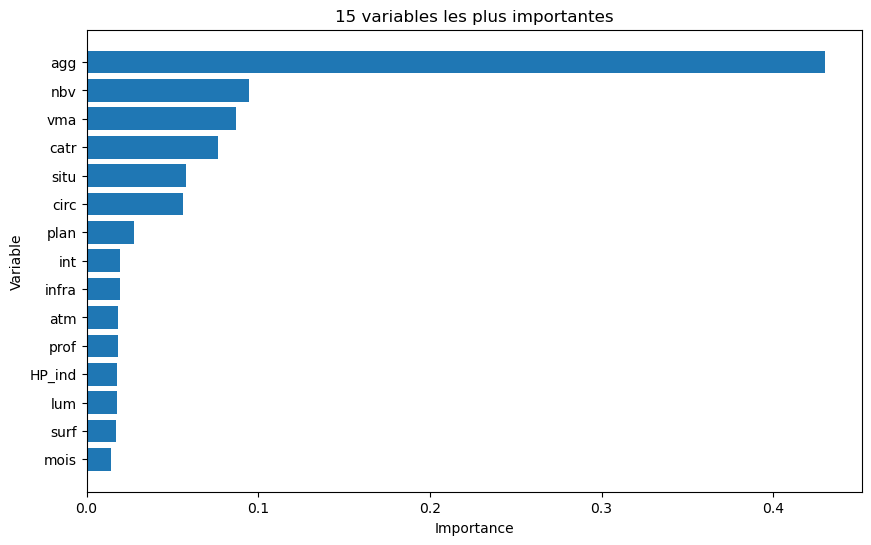

In [10]:
# Obtenir l'importance des variables à partir du modèle entraîné
importance = model.feature_importances_

# Créer un dictionnaire pour stocker l'importance de chaque variable avec son nom
feature_importance_dict = dict(zip(features, importance))

# Trier les variables par importance et sélectionner les 15 premières
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:15]

# Extraire les noms des 15 variables les plus importantes
top_feature_names = [feature[0] for feature in top_features]
top_importance = [feature[1] for feature in top_features]

# Tracer l'importance des 15 variables les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_importance)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('15 variables les plus importantes')
plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir la variable la plus importante en haut


plt.show()


In [11]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("Score F1 sur l'ensemble de test:", f1)

Score F1 sur l'ensemble de test: 0.5935059597205097


In [12]:
def graph(model, param_name, param_range):
    # Calculer les scores d'entraînement et de validation à travers la plage de valeurs de l'hyperparamètre
    train_scores, valid_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=k_fold, scoring='f1')

    # Calculer les scores moyens et les écarts-types pour les scores d'entraînement et de validation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Tracer les courbes de validation
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Score d\'entraînement')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(param_range, valid_mean, color='green', linestyle='--', marker='s', markersize=5, label='Score de validation')
    plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Valeur de ' + param_name)
    plt.ylabel('Score F1')
    plt.legend(loc='lower right')
    plt.title('Courbes de validation')
    plt.show()


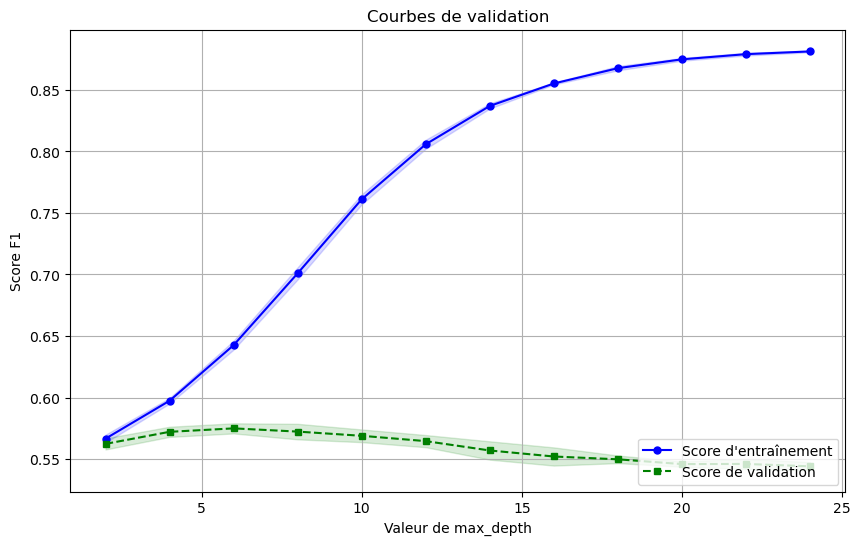

In [13]:
graph(model=xgb.XGBClassifier(objective='binary:logistic', random_state=42), param_name='max_depth', param_range=range(2,25,2))